# 稠密连接网络
首先在数学上认识一下

## 从ResNet到DenseNet
回顾一下任意函数的泰勒展开式，他把这个函数分解成越来越高阶的项。在$x$接近0时，
$$
    f(x) = f(0) + f'(0) + \frac{f''(0)}{2!}x^2 + \frac{f'''(0)}{3!}x^3 + \cdots  
$$
同样，ResNet将函数展开成
$$
    f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x})
$$
ResNet将$f$分解成两部分：一个简单的线性项和一个复杂的非线性项。下一步就是将$f$拓展成超过两部分的信息，其中一个方案就是DenseNet。

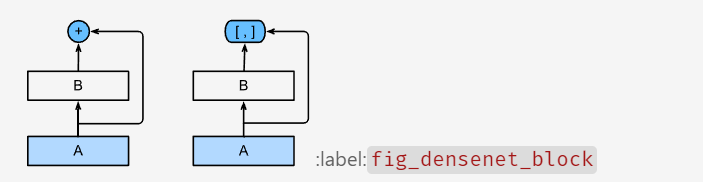

DenseNet输出是*连接*（[,]）而不是简单相加，因此在应用越来越复杂的函数序列之后，我们执行从 $\mathbf{x}$ 到其展开式的映射：
$$
    x \rightarrow [\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})], f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})]]))]
$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。实现起来非常简单，不需要添加术语而是将他们连接起来、DenseNet合格名字有变量之间的“稠密连接”而得来，最后一层与之前的所有曾紧密相连。稠密连接如下图所示：

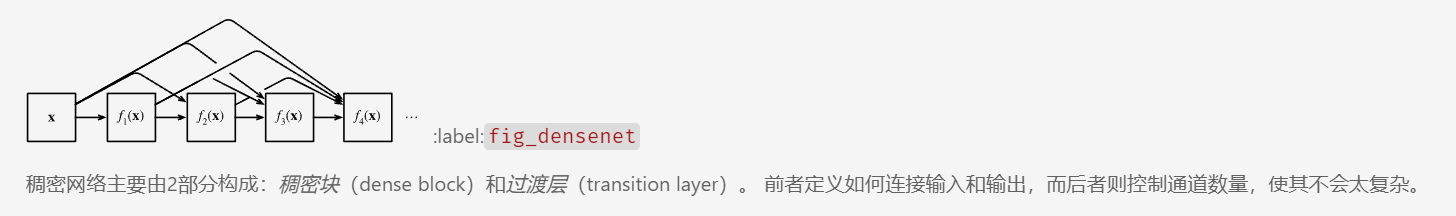

## （稠密块体）
DenseNet使用ResNet改良版的“批量规范化、激活和卷积”架构。

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels, num_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

一个*稠密块*由多个卷积块组成，每个卷积块使用相同数量的输出通道。然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(num_channels * i + input_channels, num_channels)
            )
            self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上的每个块的输入和输出
            X = torch.cat((X, Y), dim = 1)
        return X

In [3]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [过渡层]

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。而过渡层可以用来控制模型复杂度。它通过 $1 \times 1$ 卷积层来减少通道数，并使用步幅为2的平均汇聚层减半高和宽。从而进一步降低模型的复杂度。

In [4]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [5]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## DenseNet 模型
使用单卷积层和最大汇聚层

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

接下来，DenseNet使用4个稠密块。与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。这里设置成4，从而与ResNet-8保持一致。稠密块里的卷积层通道数（即增长率）设为43，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过度层来减半高和宽，并减半通道数。

In [8]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4,4,4,4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。

In [10]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

## 训练模型
由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。

loss 0.161, train acc 0.942, test acc 0.909
4116.4 examples/sec on cuda:0


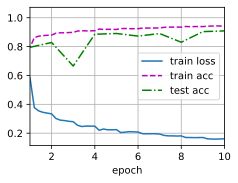

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())